# Alternative splicing analysis 
<!-- https://sailfish.readthedocs.io/en/master/sailfish.html -->

- https://github.com/comprna/SUPPA/wiki/SUPPA2-tutorial


In [87]:
from IPython import get_ipython
from IPython.core.magic import register_cell_magic

ipython = get_ipython()


@register_cell_magic
def pybash(line, cell):
    ipython.run_cell_magic('bash', '', cell.format(**globals()))

In [88]:
test = 'Python variables'

In [89]:
%%pybash
echo '{test} will be expanded'
echo '{{double braces will be replaced with single braces}}'


Python variables will be expanded
{double braces will be replaced with single braces}


## Transcript quantification


In [1]:
!mkdir suppa/

mkdir: cannot create directory ‘suppa/’: File exists


In [2]:
!cat suppa/salmon_iso.sh

PDIR=$1
quants=$2
JOBS=$3

FASTQDIR='fastq'
INDEX='/data_gilbert/home/aarab/genomes/hg38/gencode.v38/salmon_index/'

cd $PDIR
mkdir -p $quants

for fq1 in $FASTQDIR/*R1*.fastq.gz; do
	samp=`basename ${fq1}`;
    samp=${samp/_R1.fastq.gz/};
    # fq2=${fq1/_R1/_R2};
	echo "Processing sample ${samp}";
	cmd="salmon quant -i $INDEX -l ISF --gcBias -r $fq1 -p $JOBS -o $quants/$samp"
	echo $cmd
	$cmd &> $quants/${samp}.log
	echo DONE@ `date`;
done


In [ ]:
!bash suppa/salmon_iso.sh . suppa/quants 60

___
As we mentioned at the beginning, we want the TPM values of the isoforms. SUPPA2 includes a script for the extraction of this column of the Salmon output (4th columns from quant.sf files)
- `-k` indicates the row used as the index
- `-f` indicates the column to be extracted from the Salmon output


In [1]:
!multipleFieldSelection.py -i suppa/quants/*/quant.sf -k 1 -f 4 -o suppa/iso_tpm.txt

INFO: Reading file: suppa/quants/hl60_120h_t_1/quant.sf
INFO: File suppa/quants/hl60_120h_t_1/quant.sf closed.
INFO: Reading file: suppa/quants/hl60_120h_t_2/quant.sf
INFO: File suppa/quants/hl60_120h_t_2/quant.sf closed.
INFO: Reading file: suppa/quants/hl60_120h_u_1/quant.sf
INFO: File suppa/quants/hl60_120h_u_1/quant.sf closed.
INFO: Reading file: suppa/quants/hl60_120h_u_2/quant.sf
INFO: File suppa/quants/hl60_120h_u_2/quant.sf closed.
INFO: Reading file: suppa/quants/hl60_6h_t_1/quant.sf
INFO: File suppa/quants/hl60_6h_t_1/quant.sf closed.
INFO: Reading file: suppa/quants/hl60_6h_t_2/quant.sf
INFO: File suppa/quants/hl60_6h_t_2/quant.sf closed.
INFO: Reading file: suppa/quants/hl60_6h_u_1/quant.sf
INFO: File suppa/quants/hl60_6h_u_1/quant.sf closed.
INFO: Reading file: suppa/quants/hl60_6h_u_2/quant.sf
INFO: File suppa/quants/hl60_6h_u_2/quant.sf closed.
INFO: Reading file: suppa/quants/hl60_72h_t_1/quant.sf
INFO: File suppa/quants/hl60_72h_t_1/quant.sf closed.
INFO: Reading file:

For the calculation of the events, SUPPA2 requires a GTF file. Here we provide one from Ensembl. The transcripts ids in our iso_tpm file should be equal to the ids in the GTF. We have a small script in R for formatting these ids

In [7]:
# ~/Rscript ~/scripts/format_Ensembl_ids.R iso_tpm.txt

## Event calculation

### Generate the ioe files: 
Before performing the PSI calculation of the events, we need to extract from the annotation the event coordinates. SUPPA2 generates the different AS events reading transcript and gene information from the "exon" lines and creates an ioe file.

In this analysis, we are interested in testing all the different types of events:



In [2]:
%%bash 
suppa.py generateEvents \
    -i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.annotation.gtf \
    -o /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.events \
    -e SE SS MX RI FL -f ioe

/data_gilbert/home/aarab/anaconda3/envs/iso-suppa/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
INFO:eventGenerator:Reading input data.
INFO:eventGenerator:Calculating events
INFO:eventGenerator:Done


In [3]:
%%bash 
# Put all the ioe events in the same file:

awk '
    FNR==1 && NR!=1 { while (/^<header>/) getline; }
    1 {print}
' /data_gilbert/home/aarab/genomes/hg38/gencode.v34/*.ioe \
> /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.events.ioe

> __IMPORTANT:__ 

> On this occasion, we have used Ensembl. If the user decides to use RefSeq annotation, we suggest using the --pooled-genes option. RefSeq genes are labeled according to the mRNA sequences they contain, not by the gene locus. This could cause that the same id is mapped to two different places in the genome. Also, sometimes two overlapping isoforms that share some exon or splice-sites are labeled as different genes. The pooled-genes option redefines a gene as a locus with transcripts on the same strand that overlap each other in genome extent and share at least one splice-site pairwise. These issues are a big deal to calculate events and estimate PSIs, since you would be assigning wrong contributions to the events because those transcripts should be considered together as part of the same gene. There are also cases like that in Gencode and Ensembl annotation, although it is less severe.



___ 
With the ioe file generated with the event coordinates, we are ready to obtain their PSI values:


In [4]:
%%bash 
suppa.py psiPerEvent \
    -i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.events.ioe \
    -e suppa/iso_tpm.txt -o suppa/events

/data_gilbert/home/aarab/anaconda3/envs/iso-suppa/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
INFO:lib.tools:File suppa/iso_tpm.txt opened in reading mode.
INFO:psiCalculator:Buffering transcript expression levels.
INFO:lib.tools:File suppa/iso_tpm.txt closed.
INFO:lib.tools:File /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.events.ioe opened in reading mode.
INFO:psiCalculator:Calculating PSI from the ioe file.
ERROR:psiCalculator:transcript ENST00000674426.1 not found in the "expression file".
ERROR:psiCalculator:PSI not calculated for event ENSG00000092847.13;A3:chr1:35893278-35893592:35893278-35893674:+.
ERROR:psiCalculator:transcript ENST00000483916.2 not found in the "expression file".
ERROR:psiCalculator:PSI not calculated for event ENSG00000163565

In [5]:
ls suppa

events.psi  iso_tpm.txt  quants/  salmon_iso.sh


In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [144]:
def generate_boxplot_event(psi,event,samples,conds=None,save=False,output_path='suppa/plots',ylims=[-0.05, 1.05],fig=None, ax=None):

    psi_event = psi.loc[psi.index == event,samples]
    if conds: 
        psi_event.columns = conds
    
    #Create the boxplot
    data_to_plot = []
    if conds:
        for cond in set(conds):
            l = psi_event[cond].values.reshape(len([1 for c in conds if c == cond]))
            data_to_plot.append(list(map(float,l)))
    else:
        l = psi_event.values.reshape(len(samples))
        data_to_plot.append(list(map(float,l)))
    
    if not fig:
        # Create a figure instance
        fig = plt.figure(figsize=(9, 6))
    if not ax:
        # Create an axes instance
        ax = fig.add_subplot(111)
    
    # Create the boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True, sym='')
    
    # change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='.', color='#000000', alpha=0.7)
    
    # Assign different colors
    colors = ['lightblue', 'pink']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    for j in range(len(data_to_plot)):
        y = data_to_plot[j]
        x = np.random.normal(1 + j, 0.02, size=len(y))
        plt.plot(x, y, 'ko', alpha=0.5)
    
    # Custom x-axis labels if the user has input conditions
    if conds:
        ax.set_xticklabels(set(conds))
    # Leave just ticks in the bottom
    ax.get_xaxis().tick_bottom()
    ax.set_ylabel('PSI')

    # Set the title
    title = "Event: " + event.split(';')[1].split(':')[0]
    ax.set_title(title, fontsize=10)
    # Add a horizontal grid to the plot,
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    
    # Set the limits for the y axes
    ax.set_ylim(ylims)
    if save: 
        # Save the figure
        output_path = output_path + "/" + event + ".png"
        fig.savefig(save, bbox_inches='tight')
    # else: 
    #     return ax #= plt.show()

In [8]:
psi = pd.read_csv('suppa/events.psi',sep='\t')

In [24]:
samplesheet = [x.split('_') for x in list(psi.columns)]

samplesheet_hl60 = [x for x in samplesheet if len(x)==4]

samplesheet_hl60_df = pd.DataFrame(
    samplesheet_hl60,
    columns= ['cellline','time','cond','rep'],
    index=['_'.join(x) for x in samplesheet if len(x)==4]
)

In [ ]:
# Ensembl: ENSG00000168906
psi_hl = psi[samplesheet_hl60_df.index]

In [146]:
# psi_hl60[
#     psi_hl60.index.str.split(';').str[]
#     .isplit('.').str[0]in()'[ENSG00000168906'


In [54]:
samples = samplesheet_hl60_df.index.tolist()

events = psi_hl60[
    psi_hl60.index.str.split(';').str[0
    ].str.split('.').str[0].isin(['ENSG00000168906'])
].index.tolist()

In [178]:
samplesheet_hl60

[['hl60', '120h', 't', '1'],
 ['hl60', '120h', 't', '2'],
 ['hl60', '120h', 'u', '1'],
 ['hl60', '120h', 'u', '2'],
 ['hl60', '6h', 't', '1'],
 ['hl60', '6h', 't', '2'],
 ['hl60', '6h', 'u', '1'],
 ['hl60', '6h', 'u', '2'],
 ['hl60', '72h', 't', '1'],
 ['hl60', '72h', 't', '2'],
 ['hl60', '72h', 'u', '1'],
 ['hl60', '72h', 'u', '2']]

In [176]:
conds = ['_'.join([t,c]) for _,t,c,_ in samplesheet_hl60]
# samplesheet_hl60_df.time.tolist()

In [179]:
psi_hl60

,hl60_120h_t_1,hl60_120h_t_2,hl60_120h_u_1,hl60_120h_u_2,hl60_6h_t_1,hl60_6h_t_2,hl60_6h_u_1,hl60_6h_u_2,hl60_72h_t_1,hl60_72h_t_2,hl60_72h_u_1,hl60_72h_u_2
ENSG00000000003.15;A5:chrX:100635746-100636191:100635746-100636608:-,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000000003.15;A5:chrX:100635746-100636608:100635746-100636793:-,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ENSG00000000003.15;AF:chrX:100635746-100636191:100636689:100635746-100636793:100637104:-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000000003.15;SE:chrX:100630866-100632485:100632568-100633405:-,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ENSG00000000419.12;A3:chr20:50940955-50941105:50940933-50941105:-,0.049650,0.043214,0.000000,0.000000,0.22752,0.036643,0.038634,0.055485,0.069744,0.055533,0.032409,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288597.1;SE:chrX:103795986-103827005:103827078-103832060:-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,1.000000,NaN
ENSG00000288598.1;A3:chr13:41558839-41562207:41558839-41563347:+,0.243958,0.366562,0.352709,0.464448,0.60586,0.297290,0.202295,0.389537,0.329610,0.847062,0.334380,0.404591
ENSG00000288598.1;AF:chr13:41517168:41517291-41558692:41547948:41548247-41558692:+,0.627615,0.322533,0.502699,0.330695,0.00000,0.453345,0.629299,0.000000,0.639294,0.000000,0.459881,0.395436
ENSG00000288598.1;SE:chr13:41548247-41554178:41554270-41558692:+,0.585695,0.555944,0.451859,0.397229,0.39414,0.605432,0.691900,0.610463,0.207323,0.152938,0.532529,0.449808


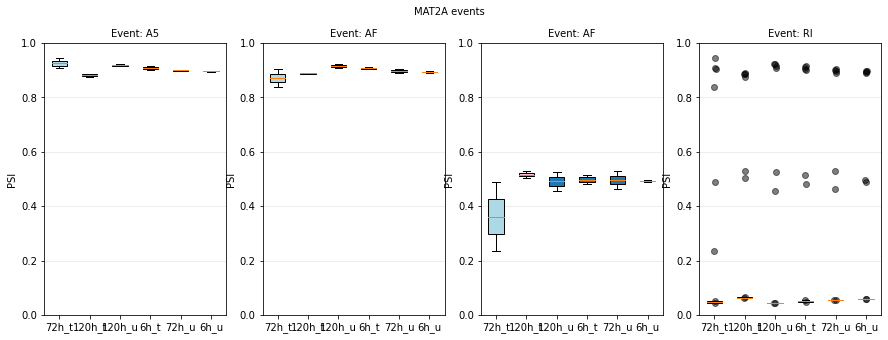

In [177]:
fig, axes = plt.subplots(1, 4,figsize=(15, 5))

for ax,event in zip(axes,events):

    _ = generate_boxplot_event(
        psi_hl60,event,samples,conds,
        ylims=[0, 1],fig=fig,ax=ax)
    
fig.suptitle('MAT2A events',fontsize=10)
fig.show()

## Differential splicing with local events


__Split files__

In [74]:
psi.columns

Index(['hl60_120h_t_1', 'hl60_120h_t_2', 'hl60_120h_u_1', 'hl60_120h_u_2',
       'hl60_6h_t_1', 'hl60_6h_t_2', 'hl60_6h_u_1', 'hl60_6h_u_2',
       'hl60_72h_t_1', 'hl60_72h_t_2', 'hl60_72h_u_1', 'hl60_72h_u_2',
       'kg1_t_1', 'kg1_t_2', 'kg1_t_3', 'kg1_u_1', 'kg1_u_2', 'kg1_u_3',
       'molm14_t_1', 'molm14_t_2', 'molm14_t_3', 'molm14_u_1', 'molm14_u_2',
       'molm14_u_3', 'ociaml2_t_1', 'ociaml2_t_2', 'ociaml2_t_3',
       'ociaml2_u_1', 'ociaml2_u_2', 'ociaml2_u_3', 'ociaml3_t_1',
       'ociaml3_t_2', 'ociaml3_t_3', 'ociaml3_u_1', 'ociaml3_u_2',
       'ociaml3_u_3', 'thp1_t_1', 'thp1_t_2', 'thp1_t_3', 'thp1_u_1',
       'thp1_u_2', 'thp1_u_3'],
      dtype='object')

In [86]:
!head ../scripts/split_file.R 

#!/usr/bin/env Rscript
#Given two pairs of lists of samples, split [1] in two files with the samples indicated in [2] and [3]

#[1] First argument: input file that we want to split
#[2] Second argument: list of samples of the first condition
#[3] Third argument: list of samples of the second condition
#[4] Fourth argument: output file of the first condition
#[5] Fifth argument: output file of the second condition

# Parse command line arguments


In [101]:
samplesheet_hl60_df

,cellline,time,cond,rep
hl60_120h_t_1,hl60,120h,t,1
hl60_120h_t_2,hl60,120h,t,2
hl60_120h_u_1,hl60,120h,u,1
hl60_120h_u_2,hl60,120h,u,2
hl60_6h_t_1,hl60,6h,t,1
hl60_6h_t_2,hl60,6h,t,2
hl60_6h_u_1,hl60,6h,u,1
hl60_6h_u_2,hl60,6h,u,2
hl60_72h_t_1,hl60,72h,t,1
hl60_72h_t_2,hl60,72h,t,2


In [104]:
time = '120h'

In [122]:
%%pybash 
Rscript ../scripts/split_file.R suppa/events.psi \
"hl60_{time}_t_2,hl60_{time}_t_1" "hl60_{time}_u_2,hl60_{time}_u_1" \
"suppa/events_hl60_{time}_t.psi" "suppa/events_hl60_{time}_u.psi"

Rscript ../scripts/split_file.R suppa/iso_tpm.txt \
"hl60_{time}_t_2,hl60_{time}_t_1" "hl60_{time}_u_2,hl60_{time}_u_1" \
"suppa/iso_tpm_hl60_{time}_t.txt" "suppa/iso_tpm_hl60_{time}_u.txt"

[1] "Parsing samples..."
[1] "Loading suppa/events.psi..."
[1] "Writing suppa/events_hl60_120h_t.psi"
[1] "Saved suppa/events_hl60_120h_t.psi"
[1] "Writing suppa/events_hl60_120h_u.psi"
[1] "Saved suppa/events_hl60_120h_u.psi"
[1] "Parsing samples..."
[1] "Loading suppa/iso_tpm.txt..."
[1] "Writing suppa/iso_tpm_hl60_120h_t.txt"
[1] "Saved suppa/iso_tpm_hl60_120h_t.txt"
[1] "Writing suppa/iso_tpm_hl60_120h_u.txt"
[1] "Saved suppa/iso_tpm_hl60_120h_u.txt"


In [123]:
time = '72h'

In [124]:
%%pybash 
Rscript ../scripts/split_file.R suppa/events.psi \
"hl60_{time}_t_2,hl60_{time}_t_1" "hl60_{time}_u_2,hl60_{time}_u_1" \
"suppa/events_hl60_{time}_t.psi" "suppa/events_hl60_{time}_u.psi"

Rscript ../scripts/split_file.R suppa/iso_tpm.txt \
"hl60_{time}_t_2,hl60_{time}_t_1" "hl60_{time}_u_2,hl60_{time}_u_1" \
"suppa/iso_tpm_hl60_{time}_t.txt" "suppa/iso_tpm_hl60_{time}_u.txt"

[1] "Parsing samples..."
[1] "Loading suppa/events.psi..."
[1] "Writing suppa/events_hl60_72h_t.psi"
[1] "Saved suppa/events_hl60_72h_t.psi"
[1] "Writing suppa/events_hl60_72h_u.psi"
[1] "Saved suppa/events_hl60_72h_u.psi"
[1] "Parsing samples..."
[1] "Loading suppa/iso_tpm.txt..."
[1] "Writing suppa/iso_tpm_hl60_72h_t.txt"
[1] "Saved suppa/iso_tpm_hl60_72h_t.txt"
[1] "Writing suppa/iso_tpm_hl60_72h_u.txt"
[1] "Saved suppa/iso_tpm_hl60_72h_u.txt"


In [125]:
time = '6h'

In [126]:
%%pybash 
Rscript ../scripts/split_file.R suppa/events.psi \
"hl60_{time}_t_2,hl60_{time}_t_1" "hl60_{time}_u_2,hl60_{time}_u_1" \
"suppa/events_hl60_{time}_t.psi" "suppa/events_hl60_{time}_u.psi"

Rscript ../scripts/split_file.R suppa/iso_tpm.txt \
"hl60_{time}_t_2,hl60_{time}_t_1" "hl60_{time}_u_2,hl60_{time}_u_1" \
"suppa/iso_tpm_hl60_{time}_t.txt" "suppa/iso_tpm_hl60_{time}_u.txt"

[1] "Parsing samples..."
[1] "Loading suppa/events.psi..."
[1] "Writing suppa/events_hl60_6h_t.psi"
[1] "Saved suppa/events_hl60_6h_t.psi"
[1] "Writing suppa/events_hl60_6h_u.psi"
[1] "Saved suppa/events_hl60_6h_u.psi"
[1] "Parsing samples..."
[1] "Loading suppa/iso_tpm.txt..."
[1] "Writing suppa/iso_tpm_hl60_6h_t.txt"
[1] "Saved suppa/iso_tpm_hl60_6h_t.txt"
[1] "Writing suppa/iso_tpm_hl60_6h_u.txt"
[1] "Saved suppa/iso_tpm_hl60_6h_u.txt"


This creates a separate file (PSI and TPM per condition). Now, we are ready to perform the differential splicing analysis

___


In [114]:
mkdir suppa/diffSplice

In [132]:
%%bash 
time='120h'
echo suppa.py diffSplice -m empirical -gc -mo WARNING \
-i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.events.ioe \
-p suppa/events_hl60_${time}_t.psi suppa/events_hl60_${time}_u.psi \
-e suppa/iso_tpm_hl60_${time}_t.txt suppa/iso_tpm_hl60_${time}_u.txt \
-o suppa/diffSplice/hl60_${time}_t_vs_u

suppa.py diffSplice -m empirical -gc -mo WARNING -i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.events.ioe -p suppa/events_hl60_120h_t.psi suppa/events_hl60_120h_u.psi -e suppa/iso_tpm_hl60_120h_t.txt suppa/iso_tpm_hl60_120h_u.txt -o suppa/diffSplice/hl60_120h_t_vs_u


In [137]:
time = '72h'

In [138]:
%%pybash 
echo suppa.py diffSplice -m empirical -gc -mo WARNING \
-i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.events.ioe \
-p suppa/events_hl60_{time}_t.psi suppa/events_hl60_{time}_u.psi \
-e suppa/iso_tpm_hl60_{time}_t.txt suppa/iso_tpm_hl60_{time}_u.txt \
-o suppa/diffSplice/hl60_{time}_t_vs_u

suppa.py diffSplice -m empirical -gc -mo WARNING -i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.events.ioe -p suppa/events_hl60_72h_t.psi suppa/events_hl60_72h_u.psi -e suppa/iso_tpm_hl60_72h_t.txt suppa/iso_tpm_hl60_72h_u.txt -o suppa/diffSplice/hl60_72h_t_vs_u


In [139]:
time = '6h'

In [140]:
%%pybash 
echo suppa.py diffSplice -m empirical -gc -mo WARNING \
-i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.events.ioe \
-p suppa/events_hl60_{time}_t.psi suppa/events_hl60_{time}_u.psi \
-e suppa/iso_tpm_hl60_{time}_t.txt suppa/iso_tpm_hl60_{time}_u.txt \
-o suppa/diffSplice/hl60_{time}_t_vs_u

suppa.py diffSplice -m empirical -gc -mo WARNING -i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.events.ioe -p suppa/events_hl60_6h_t.psi suppa/events_hl60_6h_u.psi -e suppa/iso_tpm_hl60_6h_t.txt suppa/iso_tpm_hl60_6h_u.txt -o suppa/diffSplice/hl60_6h_t_vs_u


The file `<name>_diffSplice.dpsi` gives the DeltaPSI as the difference of the mean PSI between conditions, and the p_value of this difference. We can check how is the distribution of the PSI along with the expression of the events ([this is the script](https://github.com/comprna/SUPPA/blob/master/scripts/Volcano_MA_plot.R) used for generating the following plot):

## Differential transcript usage


We have developed a new option in SUPPA2 to test differential usage of transcripts. Transcript events are important as they can describe splicing variations that are complex and cannot be encapsulated in a simple event. It's based on the same method for differential splicing with events.

First, it's necessary to obtain an ioi file from the annotation. The ioi file provides for each transcript in a gene, the set of all transcripts from that gene from which the transcript relative abundance is calculated.

In [180]:
!suppa.py generateEvents -f ioi \
    -i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.annotation.gtf \
    -o /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.isoforms

/data_gilbert/home/aarab/anaconda3/envs/iso-suppa/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
INFO:eventGenerator:Reading input data.
INFO:eventGenerator:Done


We need also to compute the PSI values of the isoforms:

In [190]:
!suppa.py psiPerIsoform \
-g /data_gilbert/home/aarab/genomes/hg38/gencode.v38/gencode.v38.annotation.gtf \
-e suppa/iso_tpm.txt -o suppa/iso

/data_gilbert/home/aarab/anaconda3/envs/iso-suppa/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
INFO:psiPerGene:Reading GTF data.
INFO:psiPerGene:Reading Expression data.
INFO:psiPerGene:Calculating inclusion and generating output.
INFO:lib.tools:Expression for transcript "ENST00000616016.5" not found. Ignoring it in calculation.
INFO:lib.tools:Expression for transcript "ENST00000618323.5" not found. Ignoring it in calculation.
INFO:lib.tools:Expression for transcript "ENST00000616125.5" not found. Ignoring it in calculation.
INFO:lib.tools:Expression for transcript "ENST00000618779.5" not found. Ignoring it in calculation.
INFO:lib.tools:Expression for transcript "ENST00000622503.5" not found. Ignoring it in calculation.
INFO:lib.tools:Expression for transcript "ENST00000

Finally, we can run the analysis of the differential transcript usage:

In [191]:
time = '120h'

In [192]:
%%pybash 
Rscript ../scripts/split_file.R suppa/iso_isoform.psi \
"hl60_{time}_t_2,hl60_{time}_t_1" "hl60_{time}_u_2,hl60_{time}_u_1" \
"suppa/isoform_hl60_{time}_t.psi" "suppa/isoform_hl60_{time}_u.psi"

[1] "Parsing samples..."
[1] "Loading suppa/iso_isoform.psi..."
[1] "Writing suppa/isoform_hl60_120h_t.psi"
[1] "Saved suppa/isoform_hl60_120h_t.psi"
[1] "Writing suppa/isoform_hl60_120h_u.psi"
[1] "Saved suppa/isoform_hl60_120h_u.psi"


In [193]:
time = '72h'

In [194]:
%%pybash 
Rscript ../scripts/split_file.R suppa/iso_isoform.psi \
"hl60_{time}_t_2,hl60_{time}_t_1" "hl60_{time}_u_2,hl60_{time}_u_1" \
"suppa/isoform_hl60_{time}_t.psi" "suppa/isoform_hl60_{time}_u.psi"

[1] "Parsing samples..."
[1] "Loading suppa/iso_isoform.psi..."
[1] "Writing suppa/isoform_hl60_72h_t.psi"
[1] "Saved suppa/isoform_hl60_72h_t.psi"
[1] "Writing suppa/isoform_hl60_72h_u.psi"
[1] "Saved suppa/isoform_hl60_72h_u.psi"


In [195]:
time = '6h'

In [196]:
%%pybash 
Rscript ../scripts/split_file.R suppa/iso_isoform.psi \
"hl60_{time}_t_2,hl60_{time}_t_1" "hl60_{time}_u_2,hl60_{time}_u_1" \
"suppa/isoform_hl60_{time}_t.psi" "suppa/isoform_hl60_{time}_u.psi"

[1] "Parsing samples..."
[1] "Loading suppa/iso_isoform.psi..."
[1] "Writing suppa/isoform_hl60_6h_t.psi"
[1] "Saved suppa/isoform_hl60_6h_t.psi"
[1] "Writing suppa/isoform_hl60_6h_u.psi"
[1] "Saved suppa/isoform_hl60_6h_u.psi"


___
This creates a separate file (PSI and TPM per condition). Now, we are ready to perform the differential splicing analysis:



### D4_vs_NC

In [ ]:
!suppa.py diffSplice -m empirical -gc -mo WARNING \
-i /data_gilbert/home/aarab/genomes/hg38/gencode.v38/gencode.v38.isoforms.ioi \
-p suppa/isoform_D4.psi suppa/isoform_NC.psi \
-e suppa/iso_tpm_D4.txt suppa/iso_tpm_NC.txt \
-o suppa/diffSplice/isoform_D4_vs_NC

In [205]:
%%bash 
time='120h'
echo suppa.py diffSplice -m empirical -gc -mo WARNING \
-i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.isoforms.ioi \
-p suppa/isoform_hl60_${time}_t.psi suppa/isoform_hl60_${time}_u.psi \
-e suppa/iso_tpm_hl60_${time}_t.txt suppa/iso_tpm_hl60_${time}_u.txt \
-o suppa/diffSplice/isoform_hl60_${time}_t_vs_u

suppa.py diffSplice -m empirical -gc -mo WARNING -i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.isoforms.ioi -p suppa/isoform_hl60_120h_t.psi suppa/isoform_hl60_120h_u.psi -e suppa/iso_tpm_hl60_120h_t.txt suppa/iso_tpm_hl60_120h_u.txt -o suppa/diffSplice/isoform_hl60_120h_t_vs_u


In [206]:
%%bash 
time='72h'
echo suppa.py diffSplice -m empirical -gc -mo WARNING \
-i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.isoforms.ioi \
-p suppa/isoform_hl60_${time}_t.psi suppa/isoform_hl60_${time}_u.psi \
-e suppa/iso_tpm_hl60_${time}_t.txt suppa/iso_tpm_hl60_${time}_u.txt \
-o suppa/diffSplice/isoform_hl60_${time}_t_vs_u

suppa.py diffSplice -m empirical -gc -mo WARNING -i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.isoforms.ioi -p suppa/isoform_hl60_72h_t.psi suppa/isoform_hl60_72h_u.psi -e suppa/iso_tpm_hl60_72h_t.txt suppa/iso_tpm_hl60_72h_u.txt -o suppa/diffSplice/isoform_hl60_72h_t_vs_u


In [ ]:
%%bash 
time='6h'
echo suppa.py diffSplice -m empirical -gc -mo WARNING \
-i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.isoforms.ioi \
-p suppa/isoform_hl60_${time}_t.psi suppa/isoform_hl60_${time}_u.psi \
-e suppa/iso_tpm_hl60_${time}_t.txt suppa/iso_tpm_hl60_${time}_u.txt \
-o suppa/diffSplice/isoform_hl60_${time}_t_vs_u

suppa.py diffSplice -m empirical -gc -mo WARNING -i /data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.isoforms.ioi -p suppa/isoform_hl60_6h_t.psi suppa/isoform_hl60_6h_u.psi -e suppa/iso_tpm_hl60_6h_t.txt suppa/iso_tpm_hl60_6h_u.txt -o suppa/diffSplice/isoform_hl60_6h_t_vs_u


# 
both analyses (events and transcripts) are complementary and do not necessarily give the same information.



In [ ]:
!for f in suppa/diffSplice/*temp.0; do o=${f/.temp.0/}; mv -v $f $o; done 

In [ ]:
!for f in suppa/diffSplice/*; do mv -v $f ${f}.txt; done 

In [ ]:
!zip -r suppa-diffSplice.zip suppa/diffSplice/

In [141]:
!date

Wed Apr  6 12:12:56 PDT 2022
